# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.19 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [20]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

UnityEnvironmentException: No Unity environment is loaded.

When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import deque

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# Define the Policy network
# It will take as input a vector of 33 elements, and output an action vector, which we normalize with tanh
# to clip vector elements between -1 and 1, as expected by the environment, which makes sense, as otherwise we
# would need to know about the concrete "physical" values behind each action value, but the environment acts as
# a black box for us.
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.hidden1 = nn.Sequential(
            nn.Linear(33, 400),
            ##nn.BatchNorm1d(400),
            nn.ReLU()
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(400, 300),
            ##nn.BatchNorm1d(300),
            nn.ReLU()
        )
        self.output = nn.Sequential(
            nn.Linear(300, 4),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.hidden1(x)
        x = self.hidden2(x)
        return self.output(x)

In [7]:
# Define the Critic network
# Here, we have a continuous action space, so the critic cannot output Q-value estimates given a state,
# and instead has to take both state and action as input, and output a scalar Q-value estimate.
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.hidden1s = nn.Sequential(
            nn.Linear(33, 100),
            nn.ReLU()
            #nn.BatchNorm1d(200)
        ) 
        self.hidden1 = nn.Sequential(
            nn.Linear(100+4, 300),
            #nn.BatchNorm1d(300),
            nn.ReLU()
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(300, 100),
            #nn.BatchNorm1d(100),
            nn.ReLU()
        )
        self.output = nn.Sequential(
            nn.Linear(100, 1)
        )
        
    def forward(self, state, action):
        xs = self.hidden1s(state.float())
        x = self.hidden1(torch.cat((xs, action), dim=1))
        x = self.hidden2(x)
        #x = self.hidden1s(state.float())
        #x = self.hidden1(torch.cat((x, action), dim=1))
        return self.output(x)

In [15]:
# Define the Agent, which maintains the learned ("online") critic network and the target critic network, to learn
# the Q-value estimates, as well as the policy network, to learn to map a state to an action.

UPDATE_EVERY = 20
NB_UPDATES = 10
LR_ACTOR = 1e-4
LR_CRITIC = 1e-3
TAU = 1e-2 # for soft update of target parameters
BUFFER_SIZE = 10000

class Agent():
    def __init__(self, batch_size, seed):
        self.seed = random.seed(seed)
        self.batch_size = batch_size
        self.critic_target = Critic().to(device)
        self.critic_online = Critic().to(device)
        self.policy_target = Policy().to(device)
        self.policy_online = Policy().to(device)
        self.optimizer_critic = optim.Adam(self.critic_online.parameters(), lr=LR_CRITIC)
        self.optimizer_policy = optim.Adam(self.policy_online.parameters(), lr=LR_ACTOR)
        self.t_step = 0
        self.experiences_buffer = deque(maxlen=BUFFER_SIZE)
        self.noise = OUNoise(4, seed)
        
    def act(self, state, i_episode, add_noise=True):
        self.policy_online.eval()
        with torch.no_grad():
            action = self.policy_online(state).cpu().data.numpy()
        self.policy_online.train()
        if add_noise:
            action += self.noise.sample(0.999**i_episode)
        return np.clip(action, -1, 1)    
        
    def step(self, state, action, next_state, reward, done):
        self.experiences_buffer.append((state, action, next_state, reward, done))
        self.t_step += 1
        if (len(self.experiences_buffer) >= self.batch_size) and (self.t_step % UPDATE_EVERY == 0):
            for j in range(NB_UPDATES):
                experiences = self.collect_experiences()
                self.learn(experiences, 0.99, self.t_step)
            self.soft_update(self.critic_online, self.critic_target, TAU)
            self.soft_update(self.policy_online, self.policy_target, TAU)
            
    def reset(self):
        self.t_step = 0
        self.noise.reset()
            
    def learn(self, experiences, gamma, t_step):
        states = torch.from_numpy(np.vstack([e[0] for e in experiences])).float().to(device)
        actions = torch.from_numpy(np.vstack([e[1] for e in experiences])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e[2] for e in experiences])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e[3] for e in experiences])).float().to(device)
        dones = torch.from_numpy(np.vstack([e[4] for e in experiences]).astype(np.uint8)).float().to(device)
        
        next_actions = self.policy_target(next_states).detach()
        Q_target_next = self.critic_target(next_states, next_actions).detach()
        Q_target = rewards + (gamma * Q_target_next * (1 - dones)).detach()
        Q_online = self.critic_online(states, actions)
        
        loss_critic = F.mse_loss(Q_online, Q_target)
        self.optimizer_critic.zero_grad()
        loss_critic.backward()
        self.optimizer_critic.step()
        
        predicted_actions = self.policy_online(states)
        loss_policy = -self.critic_online(states, predicted_actions).mean()
        self.optimizer_policy.zero_grad()
        loss_policy.backward()
        self.optimizer_policy.step()
        
        #if t_step % UPDATE_EVERY == 0:
        #self.soft_update(self.critic_online, self.critic_target, TAU)
        #self.soft_update(self.policy_online, self.policy_target, TAU)
        
    def collect_experiences(self):
        experiences = random.choices(self.experiences_buffer, k=self.batch_size)
        return experiences
        
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [10]:
import copy

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self, decay_factor=1.0):
        """Update internal state and return it as a noise sample."""
        x = self.state
        #dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        dx = self.theta * (self.mu - x) + decay_factor * self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state

In [11]:
def run_episode(agent, i_episode, max_t):
    env_info = env.reset(train_mode=True)[brain_name]
    score = 0.0
    state = torch.from_numpy(env_info.vector_observations).float().to(device)
    for i in range(max_t):
        action = agent.act(state, i_episode)
        env_info = env.step(action)[brain_name]
        next_state = torch.from_numpy(env_info.vector_observations).float().to(device)
        reward = torch.FloatTensor(env_info.rewards).to(device)
        done = torch.FloatTensor(env_info.local_done).to(device)
        agent.step(state, action, next_state, reward, done)
        score += reward.item() # assume 1 agent
        state = next_state
        if np.any(done):
            #print("done after ", i ," episodes!")
            break
    return score

In [16]:
batch_size = 128
seed = 10
agent = Agent(batch_size, seed)

In [17]:
n_episodes = 300
max_t = 1000
all_scores = []
last_scores = deque(maxlen=100)
for i in range(n_episodes):
    agent.reset()
    episode_score = run_episode(agent, i, max_t)
    last_scores.append(episode_score)
    mean_score = np.mean(np.array(last_scores))
    all_scores.append(episode_score)
    print("Episode ", i, " - Score: ", episode_score)
    if i > 0 and i % 20 == 0:
        print("Episode ", i, " - Mean score: ", mean_score)
    if i > 100 and mean_score >= 30:
        print("Problem solved!")
    torch.save(agent.policy_online.state_dict(), 'checkpoint_policy.pth')
    torch.save(agent.critic_online.state_dict(), 'checkpoint_critic.pth')

Episode  0  - Score:  0.5299999881535769
Episode  1  - Score:  0.4399999901652336
Episode  2  - Score:  0.17999999597668648
Episode  3  - Score:  1.0499999765306711
Episode  4  - Score:  0.41999999061226845
Episode  5  - Score:  2.539999943226576
Episode  6  - Score:  2.249999949708581
Episode  7  - Score:  0.7599999830126762
Episode  8  - Score:  1.579999964684248
Episode  9  - Score:  2.389999946579337
Episode  10  - Score:  1.1399999745190144
Episode  11  - Score:  1.6099999640136957
Episode  12  - Score:  0.8999999798834324
Episode  13  - Score:  1.8299999590963125
Episode  14  - Score:  0.2199999950826168
Episode  15  - Score:  0.24999999441206455
Episode  16  - Score:  0.6299999859184027
Episode  17  - Score:  0.6799999848008156
Episode  18  - Score:  0.6499999854713678
Episode  19  - Score:  1.6699999626725912
Episode  20  - Score:  1.9899999555200338
Episode  20  - Mean score:  1.12904759381
Episode  21  - Score:  0.5799999870359898
Episode  22  - Score:  0.8999999798834324
Epi

KeyboardInterrupt: 

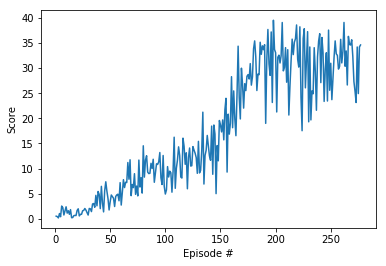

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(all_scores)+1), all_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [19]:
torch.save(agent.policy_online.state_dict(), 'checkpoint_policy_20210724.pth')
torch.save(agent.critic_online.state_dict(), 'checkpoint_critic_20210724.pth')